In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import roc_auc_score, accuracy_score
# Mis utilitarios
# from utils import *


In [2]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate, ConvLSTM2D, Reshape, Conv2D, Lambda
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

# Set Path

In [3]:
el_path_main = Path(os.getcwd()).parent
el_path_main

PosixPath('/')

In [4]:
# En caso sea en google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Tensors

In [5]:
# X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train = joblib.load(el_path_main / '2. Datos/Processed data/TRAIN_data.pkl')
# X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load(el_path_main / '2. Datos/Processed data/OOT_data.pkl')

In [6]:
# Para el caso de google cloud
X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train = joblib.load('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/TRAIN_data.pkl')
# X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/OOT_data.pkl')


In [7]:
# Reducimos el tamaño del dataset para que pueda ser ejecutado en local
desde_index = 500
X_gts_train = X_gts_train[desde_index:,:]
Y_train = Y_train[desde_index:,:]
X_gts_miss_train = X_gts_miss_train[desde_index:,:]
X_ctry_lvl_train = X_ctry_lvl_train[desde_index:,:]

In [8]:
# X_gts_train.shape, Y_train.shape, X_gts_miss_oot.shape, X_ctry_lvl_oot.shape
X_gts_train.shape, Y_train.shape, X_gts_miss_train.shape, X_ctry_lvl_train.shape

((777, 10, 96, 36, 28), (777, 12, 36, 28), (777, 10, 96, 36, 28), (777, 180))

In [9]:
def format_Y(Y):
    """
    Formatea Y para que sea un array de numpy con la forma (n_samples, n_classes)
    """
    Y = np.array(Y)
    Y = to_categorical(Y, num_classes=2)
    return Y

In [10]:
Y_train_f = format_Y(Y_train)
# Y_oot_f = format_Y(Y_oot)

In [11]:
X_gts_train.shape, Y_train.shape, X_gts_miss_train.shape, X_ctry_lvl_train.shape

((777, 10, 96, 36, 28), (777, 12, 36, 28), (777, 10, 96, 36, 28), (777, 180))

In [12]:
def gen_X_gts_for_model(X_gts, X_gts_miss):
    n_vars = X_gts.shape[1]
    lista_array = []
    for var in range(n_vars):
        X_tmp      = np.expand_dims(X_gts[:, var, :], -1)
        X_tmp_miss = np.expand_dims(X_gts_miss[:, var, :], -1)
        X = np.concat((X_tmp, X_tmp_miss), axis=-1)
        lista_array.append(X)
    return lista_array

In [13]:
# la_lista_de_arrays_oot = gen_X_gts_for_model(X_gts_oot, X_gts_miss_oot)
la_lista_de_arrays_train = gen_X_gts_for_model(X_gts_train, X_gts_miss_train)

In [14]:
la_lista_de_arrays_train[0].shape

(777, 96, 36, 28, 2)

# Version Simple

In [ ]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.2
dropout = 0.2
n_filters = 2
kernel_size = 3
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [ ]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [ ]:
mi_inp_gts = Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts')
mi_inp_ctry = Input(shape=(vars_ctry_lvl, ), name=f'input_ctry')

mi_lstm = ConvLSTM2D(filters=n_filters,
                     kernel_size=(kernel_size, kernel_size),
                     padding='same',
                     data_format = 'channels_last',
                     return_sequences=False,
                     recurrent_dropout=recurrent_dropout,
                     dropout=dropout,
                     name='conv_lstm_1')(mi_inp_gts)

mi_dense_ctry = Dense(36*28, activation='relu')(mi_inp_ctry)
mi_dense_ctry = Reshape((36, 28, 1))(mi_dense_ctry)

mi_encoded = Concatenate(axis=-1)([mi_lstm, mi_dense_ctry])
mi_encoded = Reshape((1, n_lats, n_lons, 3))(mi_encoded)
mi_encoded = Lambda(repeat_latent)(mi_encoded)

mi_decoder = ConvLSTM2D(filters=n_filters,
                        kernel_size=(kernel_size, kernel_size),
                        padding='same',
                        data_format = 'channels_last',
                        return_sequences=True,
                        recurrent_dropout=recurrent_dropout,
                        dropout=dropout,
                        name='conv_lstm_2')(mi_encoded)
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(mi_decoder)
# Model
mi_simple_model = Model(inputs=[mi_inp_gts, mi_inp_ctry], outputs=output)
mi_simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mi_simple_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry          │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts           │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1008)      │    182,448 │ input_ctry[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_1         │ (None, 36, 28, 2) │        296 │ input_gts[0][0]   │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 36, 28, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 28, 3) │          0 │ conv_lstm_1[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 36, 28, │          0 │ concatenate[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 12, 36,    │          0 │ reshape_1[0][0]   │
│                     │ 28, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_2         │ (None, 12, 36,    │        368 │ lambda[0][0]      │
│ (ConvLSTM2D)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 12, 36,    │          6 │ conv_lstm_2[0][0] │
│ (TimeDistributed)   │ 28, 2)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,118 (715.30 KB)

 Trainable params: 183,118 (715.30 KB)

 Non-trainable params: 0 (0.00 B)

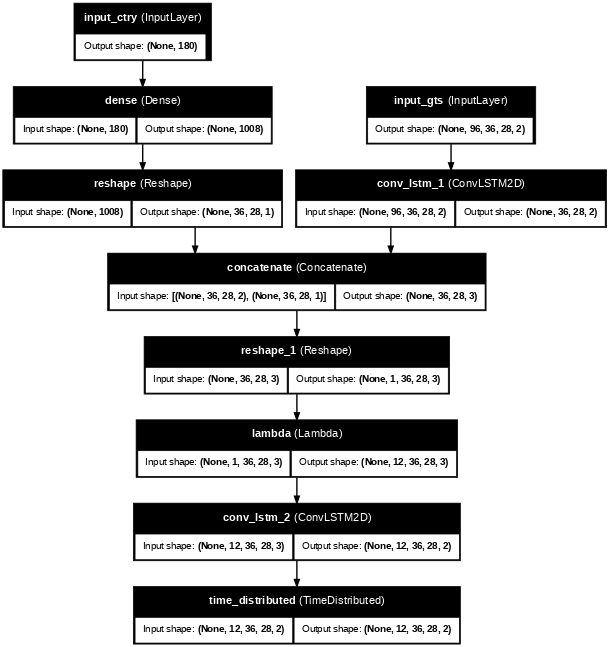

In [ ]:
plot_model(
    mi_simple_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
mi_simple_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

mi_simple_model_history = mi_simple_model.fit(x = [la_lista_de_arrays_train[9], X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.2,
                        batch_size=128,
                        epochs=20,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.7733 - loss: 0.7117 - val_accuracy: 0.7903 - val_loss: 0.7048
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.7824 - loss: 0.7021 - val_accuracy: 0.8025 - val_loss: 0.6913
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.7877 - loss: 0.6945 - val_accuracy: 0.8104 - val_loss: 0.6855
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.7949 - loss: 0.6874 - val_accuracy: 0.8152 - val_loss: 0.6779
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.7980 - loss: 0.6819 - val_accuracy: 0.8155 - val_loss: 0.6729
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.8004 - loss: 0.6767 - val_accuracy: 0.8172 - val_loss: 0.6703
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.8038 - loss: 0.6711 - val_accuracy: 0.8191 - val_loss: 0.6633
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.8067 - loss: 0.6659 - val_accuracy: 0.8291 - val_loss: 0

In [ ]:
# mi_simple_model.save_weights(el_path_main/'4. Analisis/mi_simple_model.weights.h5')


In [ ]:
# En cloud
# mi_simple_model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/mi_simple_model.weights.h5')

In [ ]:
mi_simple_model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/mi_simple_model_menos_datos.weights.h5')

# Simple V2

In [44]:
# Set of parameters that will be tunned
recurrent_dropout = 0.6
dropout = 0.6
n_filters = 2
kernel_size = 6
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [45]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [46]:
mi_inp_gts = Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts')
mi_inp_ctry = Input(shape=(vars_ctry_lvl, ), name=f'input_ctry')

mi_lstm = ConvLSTM2D(filters=n_filters,
                     kernel_size=(kernel_size, kernel_size),
                     padding='same',
                     data_format = 'channels_last',
                     return_sequences=False,
                     recurrent_dropout=recurrent_dropout,
                     dropout=dropout,
                     name='conv_lstm_1')(mi_inp_gts)

mi_dense_ctry = Dense(36*28, activation='relu')(mi_inp_ctry)
mi_dense_ctry = Reshape((36, 28, 1))(mi_dense_ctry)

mi_encoded = Concatenate(axis=-1)([mi_lstm, mi_dense_ctry])
mi_encoded = Reshape((1, n_lats, n_lons, 3))(mi_encoded)
mi_encoded = Lambda(repeat_latent)(mi_encoded)

mi_decoder = ConvLSTM2D(filters=n_filters,
                        kernel_size=(kernel_size, kernel_size),
                        padding='same',
                        data_format = 'channels_last',
                        return_sequences=True,
                        recurrent_dropout=recurrent_dropout,
                        dropout=dropout,
                        name='conv_lstm_2')(mi_encoded)
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(mi_decoder)
# Model
mi_simple_model = Model(inputs=[mi_inp_gts, mi_inp_ctry], outputs=output)
mi_simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mi_simple_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry          │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts           │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1008)      │    182,448 │ input_ctry[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_1         │ (None, 36, 28, 2) │      1,160 │ input_gts[0][0]   │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 36, 28, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 36, 28, 3) │          0 │ conv_lstm_1[0][0… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 36, 28, │          0 │ concatenate_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 12, 36,    │          0 │ reshape_3[0][0]   │
│                     │ 28, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_2         │ (None, 12, 36,    │      1,448 │ lambda_1[0][0]    │
│ (ConvLSTM2D)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 12, 36,    │          6 │ conv_lstm_2[0][0] │
│ (TimeDistributed)   │ 28, 2)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,062 (722.90 KB)

 Trainable params: 185,062 (722.90 KB)

 Non-trainable params: 0 (0.00 B)

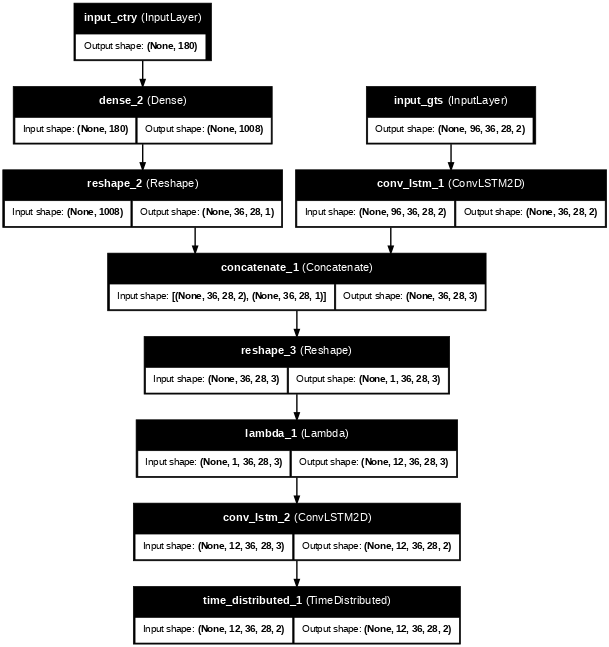

In [47]:
plot_model(
    mi_simple_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [49]:
mi_simple_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

mi_simple_model_history = mi_simple_model.fit(x = [la_lista_de_arrays_train[9], X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.4,
                        batch_size=128,
                        epochs=10,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - accuracy: 0.8205 - loss: 0.6648 - val_accuracy: 0.8723 - val_loss: 0.6366
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - accuracy: 0.8261 - loss: 0.6557 - val_accuracy: 0.8854 - val_loss: 0.6216
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step - accuracy: 0.8268 - loss: 0.6481 - val_accuracy: 0.8851 - val_loss: 0.6095
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - accuracy: 0.8285 - loss: 0.6408 - val_accuracy: 0.8916 - val_loss: 0.5909
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step - accuracy: 0.8300 - loss: 0.6328 - val_accuracy: 0.8856 - val_loss: 0.5804
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 661ms/step - accuracy: 0.8309 - loss: 0.6242 - val_accuracy: 0.8945 - val_loss: 0.5652
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step - accuracy: 0.8330 - loss: 0.6153 - val_accuracy: 0.8989 - val_loss: 0.5489
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step - accuracy: 0.8325 - loss: 0.6074 - val_accuracy: 0.8976 - val_loss: 0

In [51]:
mi_simple_model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/mi_simple_model_menos_datos_v2.weights.h5')

# Conv-LSTM

In [ ]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.2
dropout = 0.2
n_filters = 2
kernel_size = 3
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [3] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [ ]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [ ]:
# Inputs for each variable from GTS
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='relu')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent)
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry_lvl      │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        543 │ input_ctry_lvl[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_0         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_1         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_2         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_3         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_4         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_5         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_6         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_7         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_8         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_9         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2016)      │      8,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 36, 28, 2) │        296 │ input_gts_0[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 36, 28, 2) │        296 │ input_gts_1[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 36, 28, 2) │        296 │ input_gts_2[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 36, 28, 2) │        296 │ input_gts_3[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 12,267 (47.92 KB)

 Trainable params: 12,267 (47.92 KB)

 Non-trainable params: 0 (0.00 B)

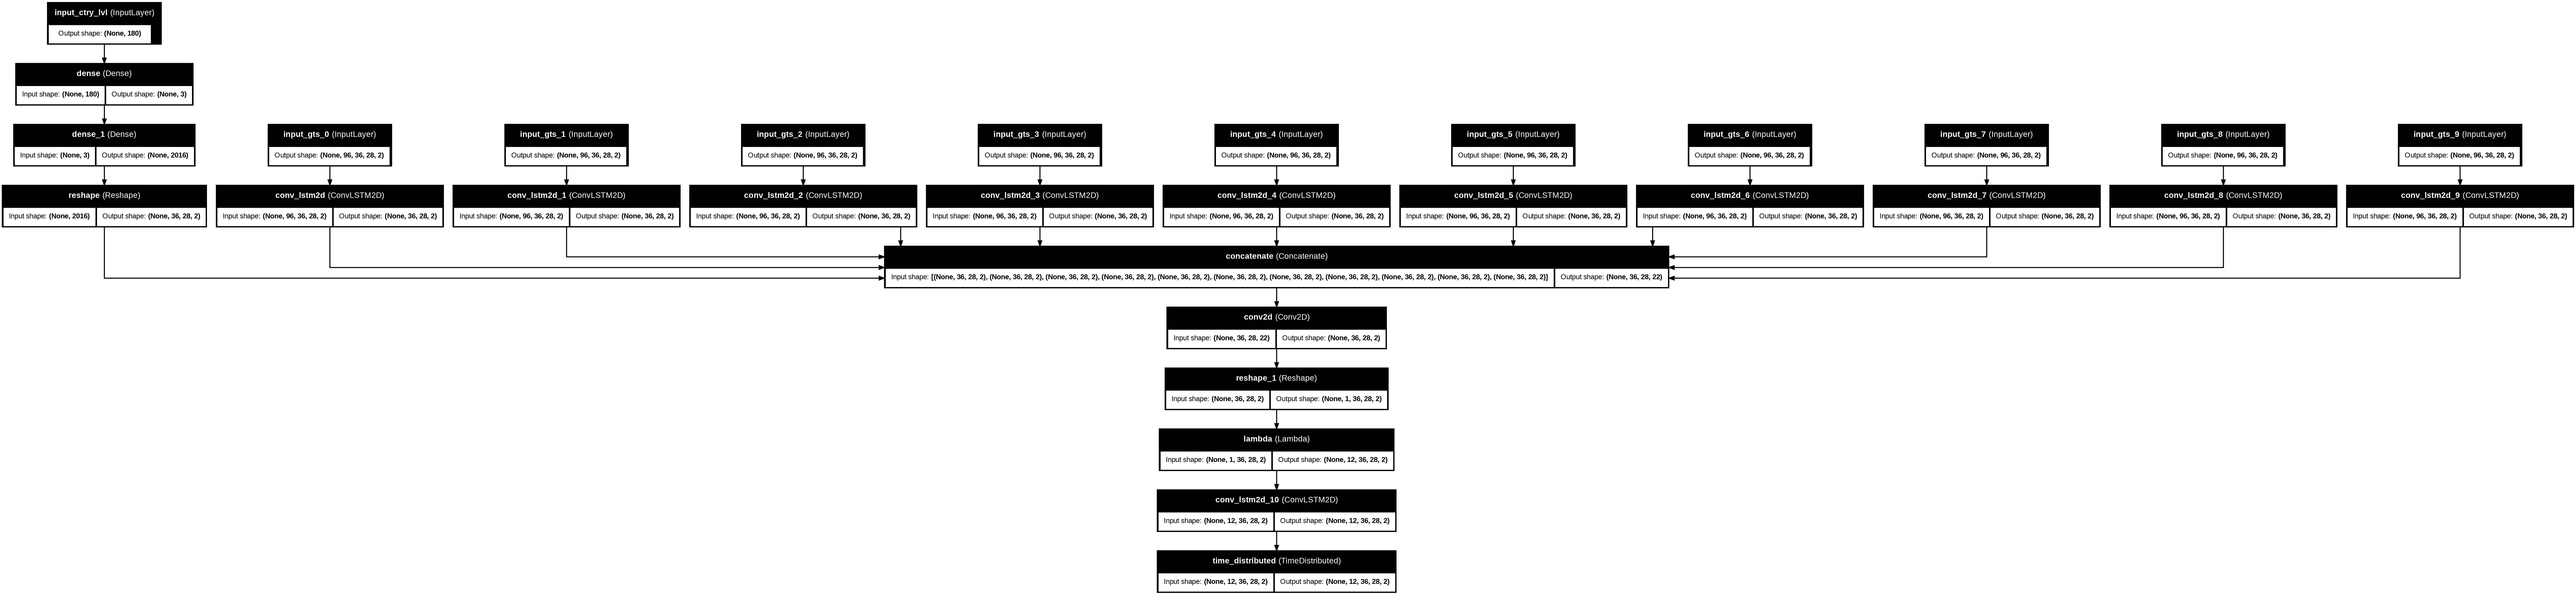

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=200,
)

In [ ]:
model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [ ]:
history = model.fit(x = la_lista_de_arrays_train + [X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.2,
                        batch_size=60,
                        epochs=20,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 159s 11s/step - accuracy: 0.7147 - loss: 0.9289 - val_accuracy: 0.7583 - val_loss: 0.8670
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7649 - loss: 0.8585 - val_accuracy: 0.7863 - val_loss: 0.8274
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7930 - loss: 0.8178 - val_accuracy: 0.8130 - val_loss: 0.7867
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8153 - loss: 0.7841 - val_accuracy: 0.8213 - val_loss: 0.7675
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8252 - loss: 0.7630 - val_accuracy: 0.8328 - val_loss: 0.7471
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8373 - loss: 0.7425 - val_accuracy: 0.8413 - val_loss: 0.7316
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8423 - loss: 0.7299 - val_accuracy: 0.8433 - val_loss: 0.7222
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8453 - loss: 0.7198 - val_accuracy: 0.8486 - val_loss: 0.7089
Epoch 

In [ ]:
# model.save_weights(el_path_main/'4. Analisis/model.weights.h5')

In [ ]:
# Si es en google Colab (modelo con)
model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/ModeloGrande_v1.weights.h5')

# CONV V2

In [ ]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.2
dropout = 0.2
n_filters = 2
kernel_size = 4
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [32] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [ ]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [ ]:
# Inputs for each variable from GTS
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='relu')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent)
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry_lvl      │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      5,792 │ input_ctry_lvl[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_0         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_1         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_2         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_3         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_4         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_5         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_6         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_7         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_8         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_9         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2016)      │     66,528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 36, 28, 2) │        520 │ input_gts_0[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 36, 28, 2) │        520 │ input_gts_1[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 36, 28, 2) │        520 │ input_gts_2[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 36, 28, 2) │        520 │ input_gts_3[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 78,752 (307.62 KB)

 Trainable params: 78,752 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

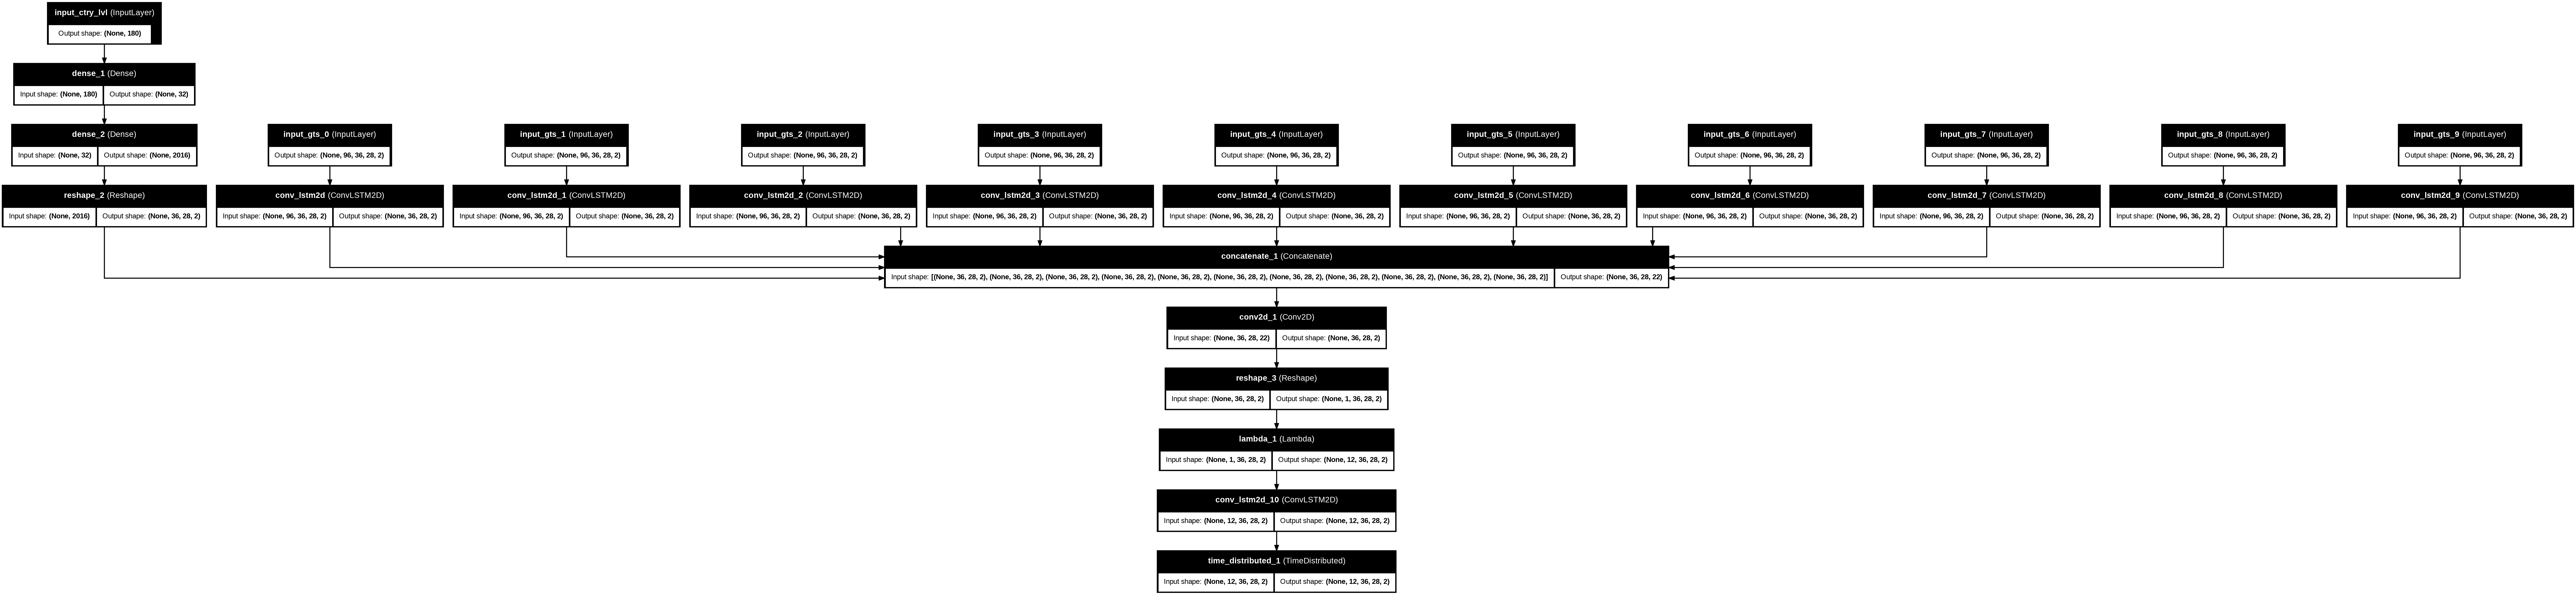

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=200,
)

In [ ]:
model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [ ]:
history = model.fit(x = la_lista_de_arrays_train + [X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.2,
                        batch_size=60,
                        epochs=20,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 167s 12s/step - accuracy: 0.9376 - loss: 0.6663 - val_accuracy: 0.9347 - val_loss: 0.6470
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9365 - loss: 0.6421 - val_accuracy: 0.9332 - val_loss: 0.6222
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9330 - loss: 0.6166 - val_accuracy: 0.9323 - val_loss: 0.5979
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9329 - loss: 0.5902 - val_accuracy: 0.9249 - val_loss: 0.5724
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9261 - loss: 0.5672 - val_accuracy: 0.9240 - val_loss: 0.5536
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9242 - loss: 0.5492 - val_accuracy: 0.9222 - val_loss: 0.5371
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9242 - loss: 0.5318 - val_accuracy: 0.9240 - val_loss: 0.5199
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9265 - loss: 0.5137 - val_accuracy: 0.9292 - val_loss: 0.5010
Epoch 

In [ ]:
# model.save_weights(el_path_main/'4. Analisis/model.weights.h5')

In [ ]:
# Si es en google Colab (modelo con)
model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/ModeloGrande_v2.weights.h5')

# CONV V3

In [14]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.6
dropout = 0.6
n_filters = 2
kernel_size = 8
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [15]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [16]:
# Inputs for each variable from GTS
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='relu')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent)
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry_lvl      │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,896 │ input_ctry_lvl[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_0         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_1         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_2         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_3         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_4         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_5         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_6         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_7         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_8         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_9         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2016)      │     34,272 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 36, 28, 2) │      1,160 │ input_gts_0[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 36, 28, 2) │      1,160 │ input_gts_1[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 36, 28, 2) │      1,160 │ input_gts_2[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 36, 28, 2) │      1,160 │ input_gts_3[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 51,520 (201.25 KB)

 Trainable params: 51,520 (201.25 KB)

 Non-trainable params: 0 (0.00 B)

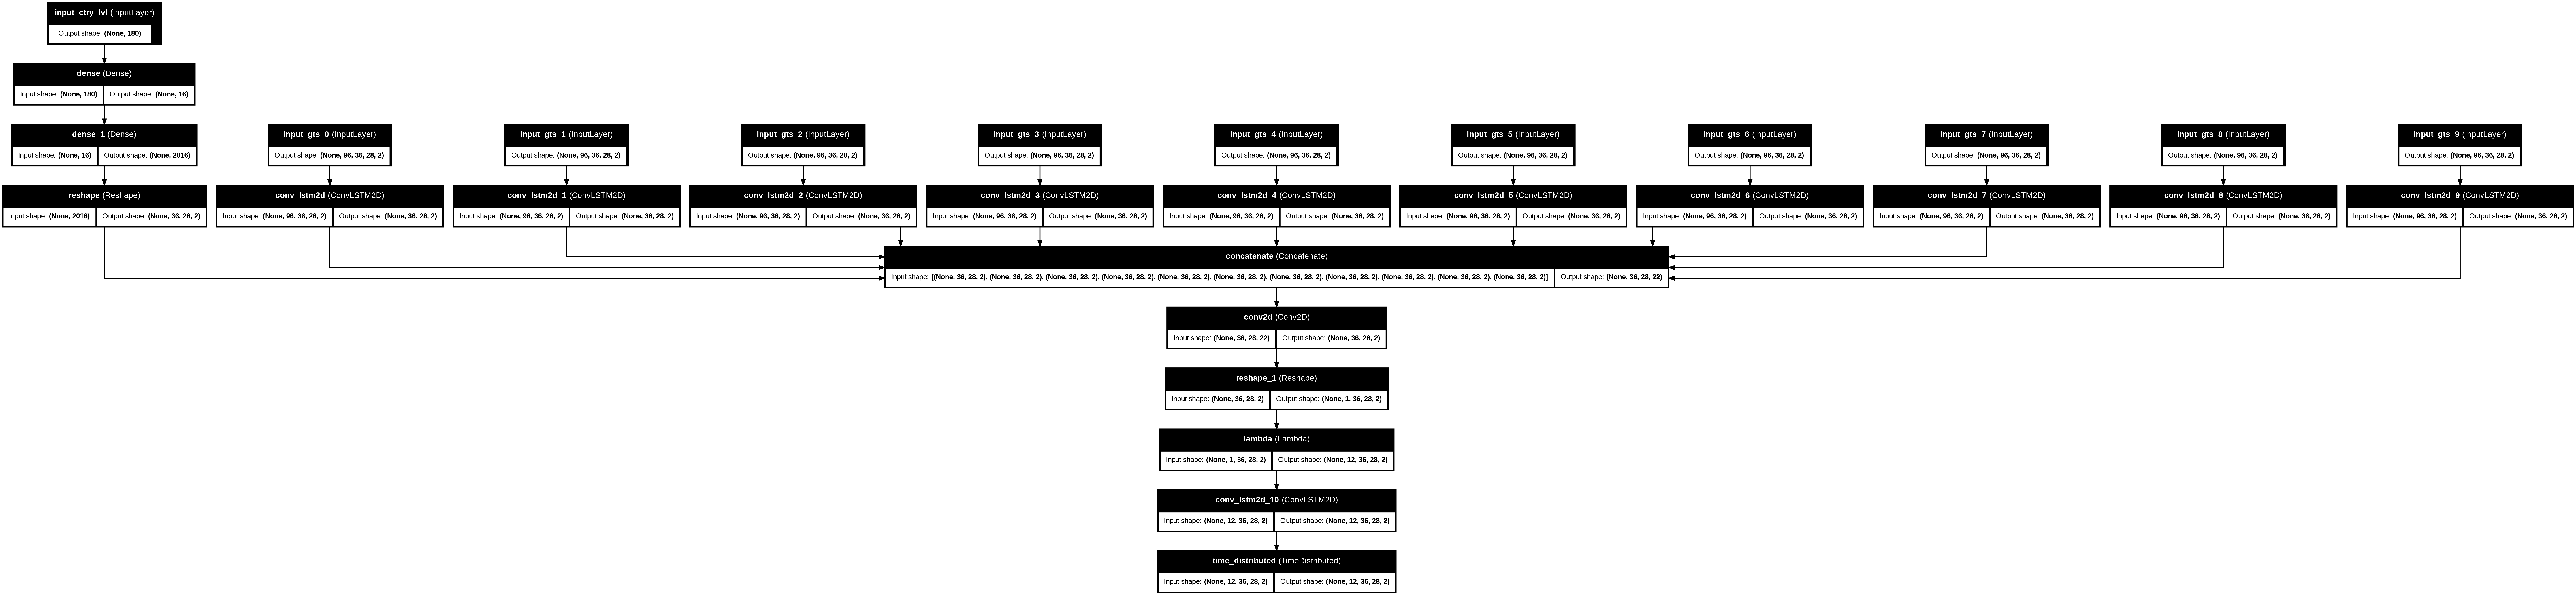

In [17]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=200,
)

In [18]:
model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [19]:
history = model.fit(x = la_lista_de_arrays_train + [X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.4,
                        batch_size=60,
                        epochs=10,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 168s 17s/step - accuracy: 0.7781 - loss: 0.7027 - val_accuracy: 0.8463 - val_loss: 0.6460
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8632 - loss: 0.6272 - val_accuracy: 0.8999 - val_loss: 0.5717
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9064 - loss: 0.5553 - val_accuracy: 0.9147 - val_loss: 0.5075
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9202 - loss: 0.4915 - val_accuracy: 0.9324 - val_loss: 0.4470
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9340 - loss: 0.4367 - val_accuracy: 0.9354 - val_loss: 0.4057
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9368 - loss: 0.3990 - val_accuracy: 0.9370 - val_loss: 0.3827
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9388 - loss: 0.3764 - val_accuracy: 0.9378 - val_loss: 0.3651
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9390 - loss: 0.3609 - val_accuracy: 0.9392 - val_loss: 0.3503
Epoch 

In [33]:
def mi_acu(y, y_hat):
    if np.unique(y).shape[0]:
        return accuracy_score(y, y_hat)
    return np.nan

def mi_gini(y, y_hat):
    if np.unique(y).shape[0]:
        return 2*roc_auc_score(y, y_hat)-1
    return np.nan


In [21]:
y_hat = model.predict(la_lista_de_arrays_train + [X_ctry_lvl_train], verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 724ms/step


In [28]:
el_th = 0.5
y_hat2 = y_hat[:,:,:,:, 1].ravel()
Y_train2 = Y_train[:,:,:,:].ravel()


In [32]:
y_hat2

array([0.282433  , 0.18962936, 0.282433  , ..., 0.4744769 , 0.57570964,
       0.4744769 ], dtype=float32)

In [35]:
print(mi_gini(Y_train2, y_hat2))
print(mi_acu(Y_train2, np.where(y_hat2>=el_th, 1, 0)))


0.08422145287607075
0.9393705067719366


In [36]:
X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/OOT_data.pkl')
la_lista_de_arrays_oot = gen_X_gts_for_model(X_gts_oot, X_gts_miss_oot)

In [38]:
y_hat = model.predict(la_lista_de_arrays_oot + [X_ctry_lvl_oot], verbose=1)
el_th = 0.5
y_hat2 = y_hat[:,:,:,:, 1].ravel()
Y_oot2 = Y_oot[:,:,:,:].ravel()

print(mi_gini(Y_oot2, y_hat2))
print(mi_acu(Y_oot2, np.where(Y_oot2>=el_th, 1, 0)))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step
0.1121952738604115
1.0


(array([2224437.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  110091.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

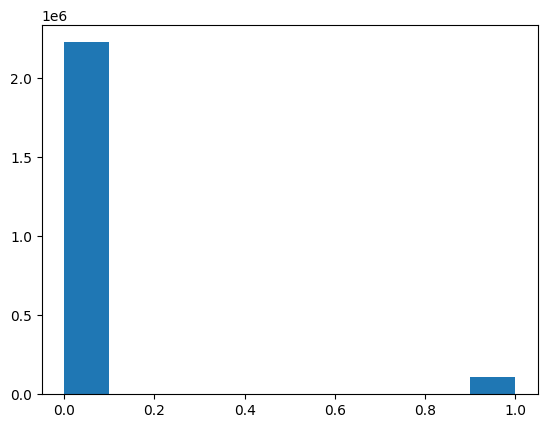

In [41]:
plt.hist(Y_oot2)

In [42]:
# Si es en google Colab (modelo con)
model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/ModeloGrande_v3.weights.h5')

# CONV V4

In [15]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.4
dropout = 0.4
n_filters = 2
kernel_size = 4
include_miss_layer = False
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [16]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [17]:
# Inputs for each variable from GTS
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='relu')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent)
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry_lvl      │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,896 │ input_ctry_lvl[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_0         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_1         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_2         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_3         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_4         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_5         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_6         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_7         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_8         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_9         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1008)      │     17,136 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 36, 28, 2) │        392 │ input_gts_0[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 36, 28, 2) │        392 │ input_gts_1[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 36, 28, 2) │        392 │ input_gts_2[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 36, 28, 2) │        392 │ input_gts_3[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 25,152 (98.25 KB)

 Trainable params: 25,152 (98.25 KB)

 Non-trainable params: 0 (0.00 B)

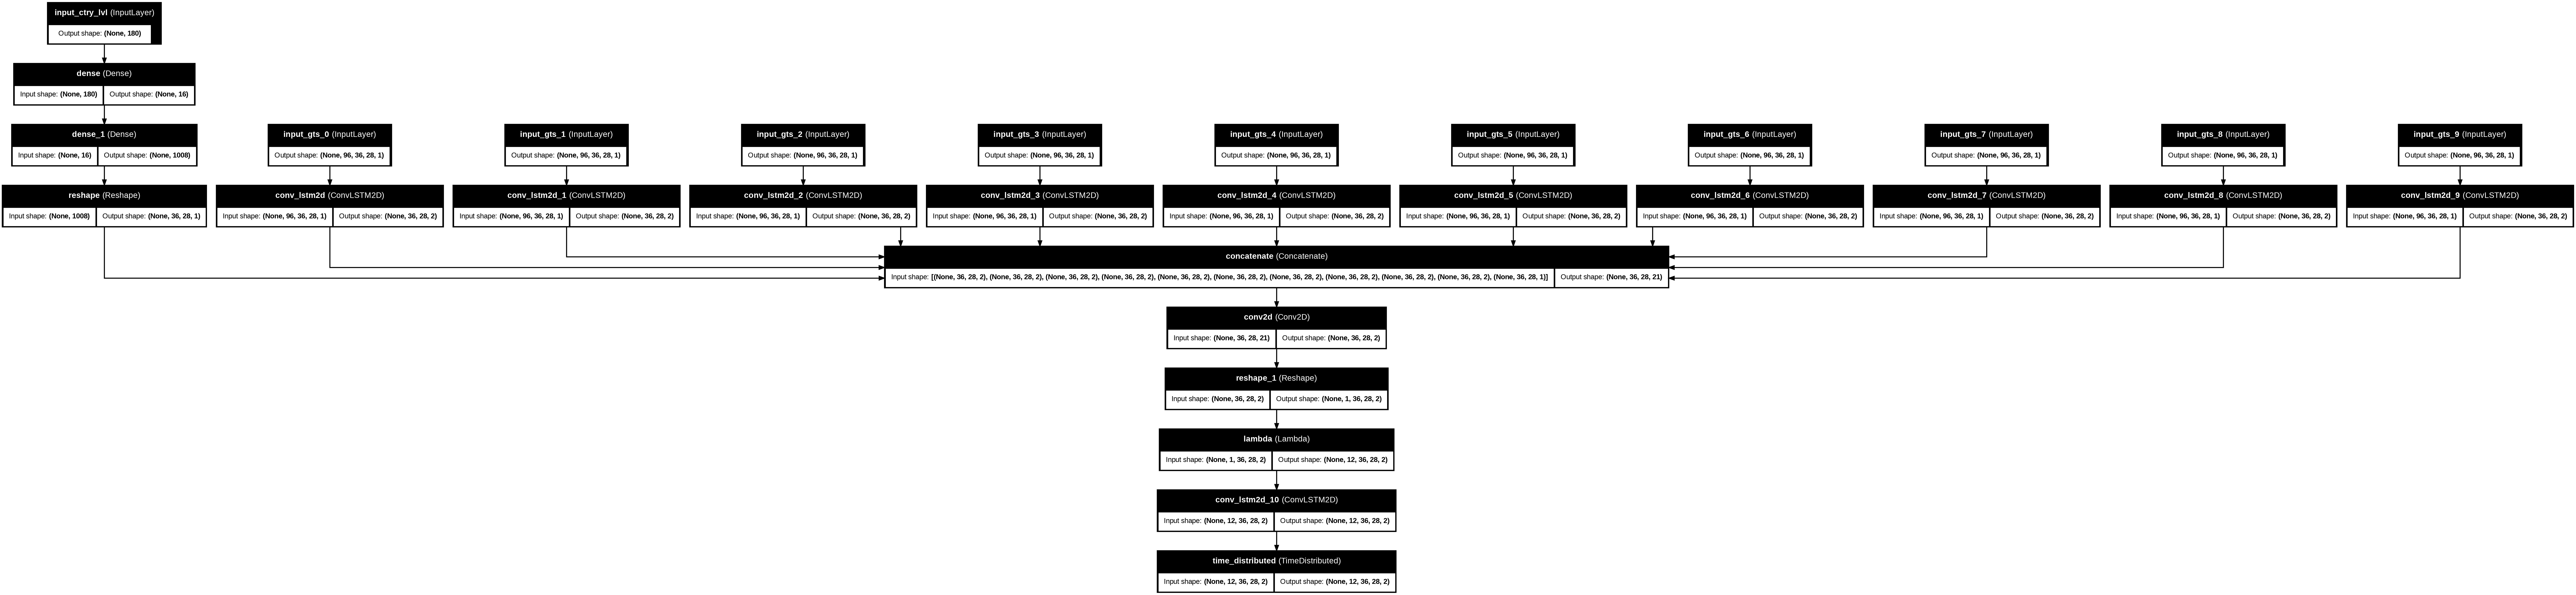

In [18]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=200,
)

In [19]:
model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['auc'])

In [20]:
la_lista_de_arrays_train[0].shape

(777, 96, 36, 28, 2)

In [21]:
np.expand_dims(la_lista_de_arrays_train[0][:,:,:,:,0], axis=-1).shape

(777, 96, 36, 28, 1)

In [22]:
la_lista_de_arrays_train_mini = [np.expand_dims(la_lista_de_arrays_train[i][:,:,:,:,0], axis=-1) for i in range(len(la_lista_de_arrays_train))]

In [24]:
history = model.fit(x = la_lista_de_arrays_train_mini + [X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.4,
                        batch_size=80,
                        epochs=5,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 145s 14s/step - auc: 0.3884 - loss: 0.8814 - val_auc: 0.7113 - val_loss: 0.7977
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - auc: 0.7238 - loss: 0.7898 - val_auc: 0.7628 - val_loss: 0.7565
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - auc: 0.7716 - loss: 0.7481 - val_auc: 0.7933 - val_loss: 0.7260
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - auc: 0.8040 - loss: 0.7200 - val_auc: 0.8198 - val_loss: 0.7063
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - auc: 0.8284 - loss: 0.7015 - val_auc: 0.8405 - val_loss: 0.6895


In [40]:
def mi_acu(y, y_hat):
    if np.unique(y).shape[0]:
        return accuracy_score(y, y_hat)
    return np.nan

def mi_gini(y, y_hat):
    if np.unique(y).shape[0]>1:
        return 2*roc_auc_score(y, y_hat)-1
    return np.nan


In [31]:
y_hat = model.predict(la_lista_de_arrays_train_mini + [X_ctry_lvl_train], verbose=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step


In [32]:
el_th = 0.5
y_hat2 = y_hat[:,:,:,:, 1].ravel()
Y_train2 = Y_train[:,:,:,:].ravel()


In [37]:
y_hat.shape, Y_train.shape, y_hat[:,:,:,:, 1].shape

((777, 12, 36, 28, 2), (777, 12, 36, 28), (777, 12, 36, 28))

In [33]:
y_hat2

array([0.48521304, 0.48521304, 0.48521304, ..., 0.48521304, 0.48521304,
       0.48521304], dtype=float32)

In [41]:
print(mi_gini(Y_train2, y_hat2))
print(mi_acu(Y_train2, np.where(y_hat2>=el_th, 1, 0)))


0.016488599836300688
0.8895939945047088


In [27]:
X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/OOT_data.pkl')
la_lista_de_arrays_oot = gen_X_gts_for_model(X_gts_oot, X_gts_miss_oot)
la_lista_de_arrays_oot_mini = [np.expand_dims(la_lista_de_arrays_oot[i][:,:,:,:,0], axis=-1) for i in range(len(la_lista_de_arrays_oot))]


In [29]:
y_hat = model.predict(la_lista_de_arrays_oot_mini + [X_ctry_lvl_oot], verbose=1)
el_th = 0.5
y_hat2 = y_hat[:,:,:,:, 1].ravel()
Y_oot2 = Y_oot[:,:,:,:].ravel()

print(mi_gini(Y_oot2, y_hat2))
print(mi_acu(Y_oot2, np.where(y_hat2>=el_th, 1, 0)))


0.008623319609168734
0.8942694197713628


In [ ]:
plt.hist(Y_oot2)

In [42]:
# Si es en google Colab (modelo con)
model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/ModeloGrande_v4.weights.h5')

# CONV V5

In [43]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.6
dropout = 0.6
n_filters = 2
kernel_size = 7
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [32] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [44]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [45]:
# Inputs for each variable from GTS
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='tanh')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='tanh')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent)
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry_lvl      │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     11,584 │ input_ctry_lvl[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_0         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_1         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_2         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_3         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_4         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_5         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_6         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_7         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_8         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_9         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2016)      │    131,040 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_11      │ (None, 36, 28, 2) │      1,576 │ input_gts_0[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_12      │ (None, 36, 28, 2) │      1,576 │ input_gts_1[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_13      │ (None, 36, 28, 2) │      1,576 │ input_gts_2[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_14      │ (None, 36, 28, 2) │      1,576 │ input_gts_3[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 162,124 (633.30 KB)

 Trainable params: 162,124 (633.30 KB)

 Non-trainable params: 0 (0.00 B)

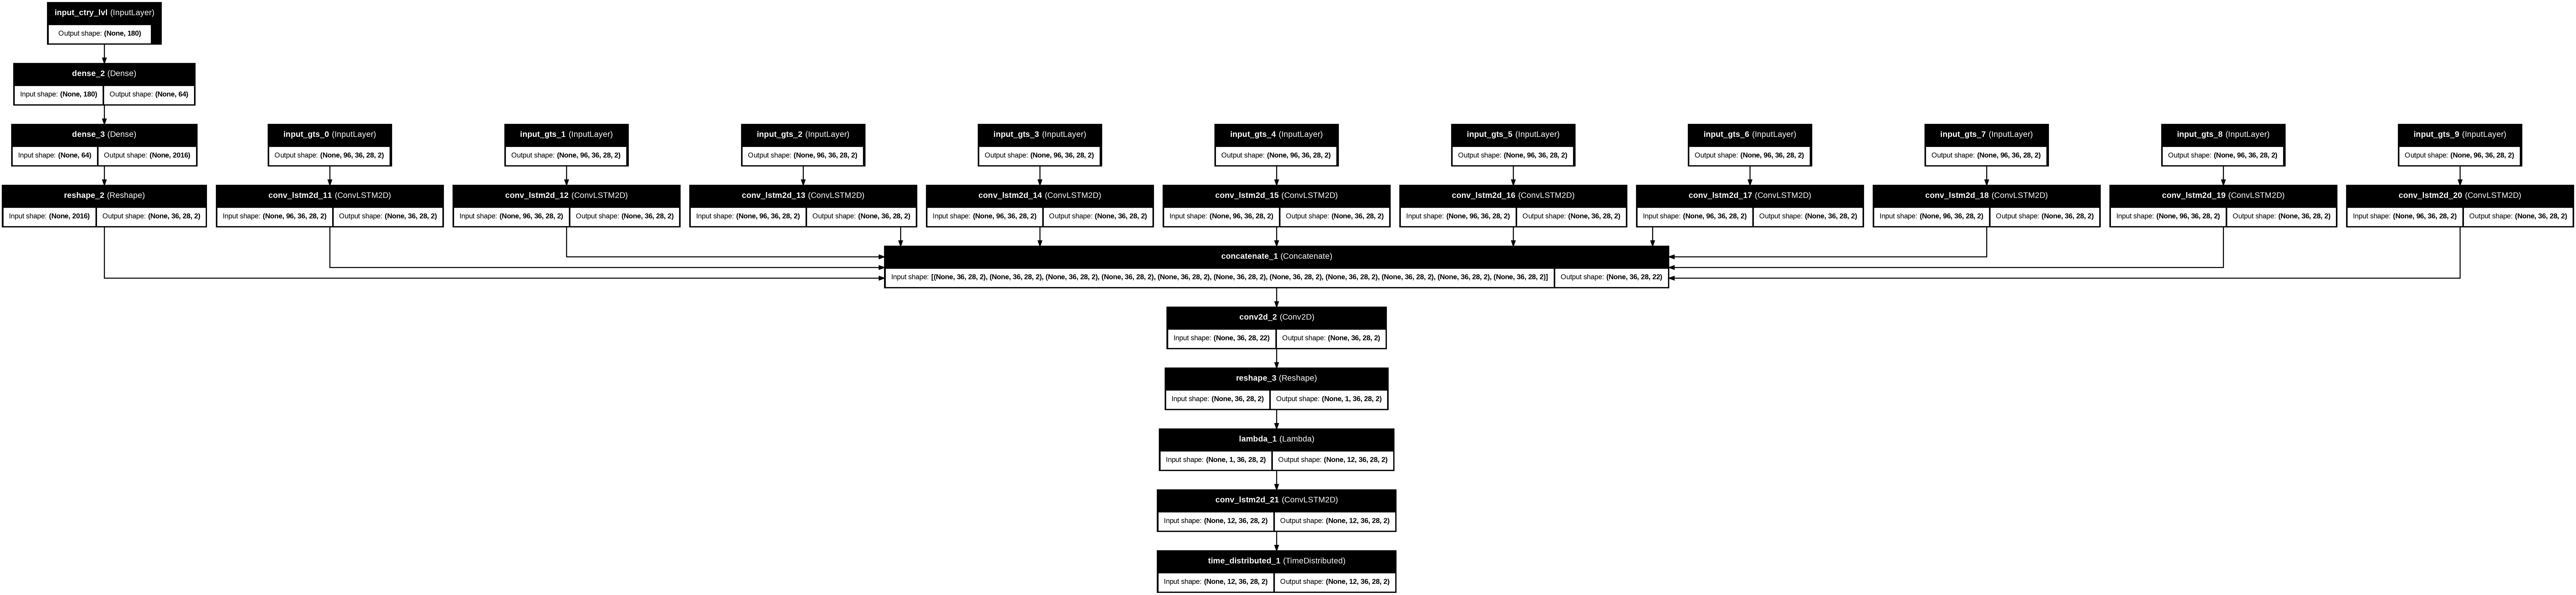

In [46]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=200,
)

In [47]:
model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['auc'])

In [48]:
la_lista_de_arrays_train[0].shape

(777, 96, 36, 28, 2)

In [ ]:
np.expand_dims(la_lista_de_arrays_train[0][:,:,:,:,0], axis=-1).shape

(777, 96, 36, 28, 1)

In [ ]:
la_lista_de_arrays_train_mini = [np.expand_dims(la_lista_de_arrays_train[i][:,:,:,:,0], axis=-1) for i in range(len(la_lista_de_arrays_train))]

In [49]:
history = model.fit(x = la_lista_de_arrays_train + [X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.4,
                        batch_size=80,
                        epochs=5,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-49-4154615100>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 8884368864 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_85807]

In [ ]:
def mi_acu(y, y_hat):
    if np.unique(y).shape[0]:
        return accuracy_score(y, y_hat)
    return np.nan

def mi_gini(y, y_hat):
    if np.unique(y).shape[0]>1:
        return 2*roc_auc_score(y, y_hat)-1
    return np.nan


In [ ]:
y_hat = model.predict(la_lista_de_arrays_train + [X_ctry_lvl_train], verbose=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step


In [ ]:
el_th = 0.5
y_hat2 = y_hat[:,:,:,:, 1].ravel()
Y_train2 = Y_train[:,:,:,:].ravel()


In [ ]:
y_hat.shape, Y_train.shape, y_hat[:,:,:,:, 1].shape

((777, 12, 36, 28, 2), (777, 12, 36, 28), (777, 12, 36, 28))

In [ ]:
y_hat2

array([0.48521304, 0.48521304, 0.48521304, ..., 0.48521304, 0.48521304,
       0.48521304], dtype=float32)

In [ ]:
print(mi_gini(Y_train2, y_hat2))
print(mi_acu(Y_train2, np.where(y_hat2>=el_th, 1, 0)))


0.016488599836300688
0.8895939945047088


In [ ]:
X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/OOT_data.pkl')
la_lista_de_arrays_oot = gen_X_gts_for_model(X_gts_oot, X_gts_miss_oot)
la_lista_de_arrays_oot_mini = [np.expand_dims(la_lista_de_arrays_oot[i][:,:,:,:,0], axis=-1) for i in range(len(la_lista_de_arrays_oot))]


In [ ]:
y_hat = model.predict(la_lista_de_arrays_oot + [X_ctry_lvl_oot], verbose=1)
el_th = 0.5
y_hat2 = y_hat[:,:,:,:, 1].ravel()
Y_oot2 = Y_oot[:,:,:,:].ravel()

print(mi_gini(Y_oot2, y_hat2))
print(mi_acu(Y_oot2, np.where(y_hat2>=el_th, 1, 0)))


0.008623319609168734
0.8942694197713628


(array([ 314685.,  258741.,  107226.,       0., 8111880.,   20979.,
         226884.,  125097.,   31080.,  202020.]),
 array([0.12717536, 0.20823507, 0.28929478, 0.37035447, 0.4514142 ,
        0.53247392, 0.61353362, 0.69459331, 0.775653  , 0.8567127 ,
        0.93777245]),
 <BarContainer object of 10 artists>)

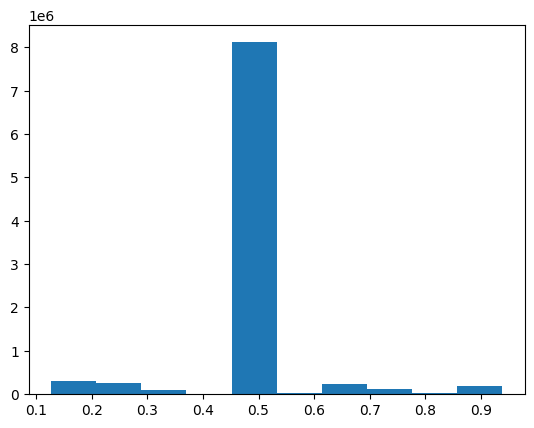

In [51]:
plt.hist(y_hat2)

In [ ]:
# Si es en google Colab (modelo con)
model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/ModeloGrande_v4.weights.h5')

# FIN